# npr MC1: Cleantech Retrieval Augemented Generation

**Dominik Filliger, Nils Fahrni, Noah Leuenberger**

> The topic of Mini-Challenge 1 is retrieval augmented generation (RAG) incorporating a combination of unsupervised learning, pre-training and in-context learning techniques.

- [Description of the task](https://spaces.technik.fhnw.ch/storage/uploads/spaces/81/exercises/NPR-Mini-Challenge-1-Cleantech-RAG-1708982891.pdf)
- [Introduction to RAG](https://spaces.technik.fhnw.ch/storage/uploads/spaces/81/exercises/Retrieval-Augmented-Generation-Intro-1709021241.pdf)

This notebook serves as the main entry point for our solution to the NPR Mini-Challenge 1. We will provide a detailed explanation of our approach and the code we used to solve the task. However, we have outsourced the code for the evaluation, Langchain LLM model creation and vectorstore interaction to script files which can be found in the `src` directory.

Additionally, scripts for the development subset and subset evaluation set creation can be found in the `scripts` directory and will be referenced in their respective sections.


# Setup


In [2]:
import os
from dotenv import load_dotenv
from tqdm import tqdm
load_dotenv()
from src.generation import get_llm_model, LLMModel
azure_model = get_llm_model(LLMModel.GPT_3_AZURE)

## Observability & Monitoring

> Phoenix is an open-source observability library designed for experimentation, evaluation, and troubleshooting. It allows AI Engineers and Data Scientists to quickly visualize their data, evaluate performance, track down issues, and export data to improve.

We will use Phoenix to visualize traces to quickly debug pipelines. The library offers way more feature which we will not use. Down below we add the Phoenix callbacks to Langchain, our main library for the solution, to visualize the traces.


In [3]:
from phoenix.trace.langchain import LangChainInstrumentor
import phoenix as px

px.close_app()
session = px.launch_app()

LangChainInstrumentor().instrument()

/Users/nils/Documents/Classes/npr/npr-rag/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No active session to close
🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📺 To view the Phoenix app in a notebook, run `px.active_session().view()`
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


To get quick access to the Phoenix dashboard, the dashboard is rendered in the notebook. The dashboard is interactive and can be used to explore the traces.


In [4]:
session.view()

📺 Opening a view to the Phoenix app. The app is running at http://localhost:6006/


# Data Loading & Preprocessing

In order to save time and resources, we will only load a randomly sampled subset of the data. This subset will be used for development and testing purposes. The full dataset will be used for a final evaluation of our chosen approach.

In [5]:
import pandas as pd
df = pd.read_csv('data/Cleantech Media Dataset/cleantech_media_dataset_v2_2024-02-23_subset.csv')
df.head()

,Unnamed: 0,title,date,author,content,domain,url
0,77927,'Next level ': Iberdrola plans $ 2.6bn gigawat...,2021-12-02,NaN,['Plans for a gigawatt-scale electrolyser to f...,rechargenews,https://www.rechargenews.com/news/2-1-1111100
1,81316,"Appalachian Power Issues RFP for 1,100 MW of R...",2022-01-19,NaN,['Appalachian Power has issued a new request f...,solarindustrymag,https://solarindustrymag.com/appalachian-power...
2,1323,Orsted's Green Plans Lag Its Peers,2021-06-04,NaN,"[""Danish utility Orsted intends to spend over ...",energyintel,https://www.energyintel.com/0000017b-a7dd-de4c...
3,78039,Offshore wind ' a massive untapped potential '...,2022-08-29,NaN,['Offshore wind power is rapidly emerging as a...,rechargenews,https://www.rechargenews.com/news/2-1-1286193
4,16584,Germany Threatens To Derail EU Green Deal Over...,2023-03-03,NaN,['The “ Climate Chancellor ” needs to draw a l...,cleantechnica,https://cleantechnica.com/2023/03/03/germany-t...


## Splitting content into paragraphs

The content is currently stored as a string which represents a list of string. 

As a base start we will take this string and transform it into a list of strings, explode this list into multiple rows and then remove the duplicates. This will allow us to work with the data in a more structured way. 

On top of that we will also remove special characters and empty strings from the content, following suit of our embedding model (bge-small-en).

To do all this we will use the custom `Preprocessor` class.

###### todo validate if this is the correct approach

In [6]:
from src.preprocessing.preprocessor import Preprocessor

default_preprocesser = Preprocessor(df)
default_df = default_preprocesser.preprocess()

# Indexing

The indexing involves creating a vector representation of the content. 

In [7]:
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

bge_embeddings = HuggingFaceBgeEmbeddings(
    model_name="BAAI/bge-small-en", 
    model_kwargs={"device": "cpu"}, 
    encode_kwargs={"normalize_embeddings": True}
)

In [8]:
from langchain_core.documents import Document

def create_documents(df):
    docs = []
    for index, row in tqdm(df.iterrows()):
        content = row['content']

        row = row.fillna('')

        metadata = {
            "url": row['url'],
            "domain": row['domain'],
            "title": row['title'],
            "author": row['author'],
            "date": row['date']
        }

        docs.append(Document(page_content=content, metadata=metadata))

    return docs

documents = create_documents(default_df)

assert len(documents) == len(default_df)

0it [00:00, ?it/s]

1533it [00:00, 17505.00it/s]


## Vector Store

We will use [ChromaDB](https://www.trychroma.com/) to store the embeddings. For easier interaction with the embeddings, we will use the VectorStore class which is a wrapper around the embeddings and ChromaDB. It provides a simple interface to interact with the embeddings and ChromaDB functionality we need for the task.

### ChromaDB Setup

If the environment variables `CHROMADB_HOST` or `CHROMADB_PORT` are not set, the VectorStore will use a local non-persistent ChromaDB client, which is not recommended. Instead we recommend setting up a ChromaDB instance. The ChromaDB instance can be set up using the following command and Docker:

```bash
docker-compose up -d chromadb
```

Set the environment variables `CHROMADB_HOST` and `CHROMADB_PORT` to the host and port of the ChromaDB instance. The default values are `localhost` and `8192`.

### VectorStore Usage

The vector store is directly tied to the embeddings. Therefore a vector store is embedding specific and can only be used with the embeddings it was created with.

In [9]:
from src.vectorstore import VectorStore

print("ChromeDB Host: ", os.getenv('CHROMADB_HOST'))
print("ChromeDB Port: ", os.getenv('CHROMADB_PORT'))

bge_vector_store = VectorStore(embedding_function=bge_embeddings,
                               collection="cleantech-bge-small-en")

ChromeDB Host:  100.109.183.32
ChromeDB Port:  8192


In the next step we will add the prepared documents from the previous step to the VectorStore.

In [10]:
%%script false --no-raise-error
bge_vector_store.add_documents(documents, verbose=True, batch_size=128)

After adding the documents to the vector store we can now perform similarity searches on the documents to verify that the interaction with the vector store works as expected.

In [11]:
bge_vector_store.similarity_search_w_scores("The company is also aiming to reduce gas flaring?")

[(Document(page_content='The company in 2020 announced its intention to reduce operational GHG emissions intensity by 35% to 45% by 2030, a revision from the previous goal of 5% to 15%, and to reach net zero emissions by 2050.\n\nThe path to net zero will involve tools such as emissions offsets and carbon capture, utilization and sequestration, Lance said.\n\nWithin the ESG initiatives, Lance and Sheffield also stressed the importance of curbing routine natural gas flaring, which remains a stubborn challenge in the Permian despite progress made on reducing flaring intensity.\n\nOther measures such as electrifying fracture fleets, and better monitoring of methane leaks, will be crucial as well, they said.', metadata={'author': '', 'date': '2021-03-05', 'domain': 'naturalgasintel', 'title': 'ConocoPhillips, Pioneer Natural CEOs Preach Discipline as Permian Activity Rebounds', 'url': 'https://www.naturalgasintel.com/conocophillips-pioneer-natural-ceos-preach-discipline-as-permian-activity

# Baseline Pipeline

The baseline pipeline is a first simple implementation of the RAG pipeline.


In [12]:
rag_prompt = """
Answer the question to your best knowledge when looking at the following context:
{context}
                
Question: {question}
"""

In [13]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableParallel

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain_from_docs = (
        RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
        | ChatPromptTemplate.from_template(rag_prompt)
        | azure_model
        | StrOutputParser()
)

rag_chain_with_source = RunnableParallel(
    {
        "context": bge_vector_store.get_retriever(), 
        "question": RunnablePassthrough()
    }
).assign(answer=rag_chain_from_docs)

In [14]:
rag_chain_with_source.invoke("Is the company aiming to reduce gas flaring?")

{'context': [Document(page_content='However, the report does concede that “ there does seem to be a sounder logic of fewer high-intensity gas users connecting to a smaller network ”. These users include gas peaker plants, heavy industry requiring high-temperature heat, aviation and long-distance haulage.\n\nThe study does not point out that when hydrogen is combusted, it reacts with nitrogen in the air to produces nitrogen oxides that are greenhouse gases.\n\n* LETI is a UK-based voluntary network consisting of more than 1,000 developers, engineers, housing associations, architects, planners, academics, sustainability professionals, contractors and facilities managers.\n\nRecharge is part of DN Media Group. To read more about DN Media Group, click here\n\nRecharge is part of DN Media Group AS. From November 1st DN Media Group is responsible for controlling your data on Recharge.', metadata={'author': '', 'date': '2021-02-10', 'domain': 'rechargenews', 'title': 'Why using clean hydrogen

# Evaluation

In order to compare the performance of different pipelines we need to evaluate them. The evaluation is done with the `ragas` library. The library provides a function to evaluate the performance of the pipeline. `ragas` provides predefined metrics for the evaluation which are described in the [documentation](https://docs.ragas.io/en/stable/concepts/metrics/index.html). We will use the following metrics to evaluate the performance of our pipelines:

- **Context Relevancy**: The context relevancy metric measures how well the generated response is related to the context. The metric is calculated as the cosine similarity between the context and the generated response.

## Evaluation Set
In order to provide a fair comparison between the different pipelines we will use the same evaluation set for all pipelines. The evaluation set was created before hand with the script `scripts/generate_testset.py`. With that we can evaluate the performance of our pipelines with a subset of the data which saves time and resources.

In [15]:
df_eval_subset = pd.read_csv('data/Cleantech Media Dataset/cleantech_media_dataset_v2_2024-02-23_subset_eval.csv')
df_eval_subset = df_eval_subset.dropna(subset=['answer'])
df_eval_subset = df_eval_subset.drop_duplicates().sample(10)
df_eval_subset

,question,relevant_chunk,answer,question_complexity,episode_done
29,How could Germany's potential abstention from ...,"[""['The “ Climate Chancellor ” needs to draw a...",If Germany abstains from the EU vote to end th...,simple,True
20,What is the history and development of the Pap...,"[""['Waren ( Müritz), the first city to have MW...",The Papenberg geothermal heating plant in Ware...,simple,True
8,What actions is the Department of Energy takin...,"[""clean energy economy, ” said U.S. Secretary ...",The Department of Energy is working to jump-st...,reasoning,True
10,What is the capacity of Duke Energy's new util...,"[""['Duke Energy customers in Northern Kentucky...",The new utility-scale solar project in Norther...,simple,True
44,What is the DOE doing to promote diversity and...,"[""Black ( 8%), and Indigenous worker ( 1%) rep...",The DOE has designed the Advancing Equity thro...,simple,True
47,What are the factors affecting power generatio...,['do their jobs of making energy until they\'r...,The factors affecting power generation in grou...,reasoning,True
11,What factors are necessary to unlock renewable...,['for solar-based corporate power purchase agr...,Orsted states that regulatory mandates or ince...,simple,True
43,What is the goal of President Biden's Investin...,"[""['WASHINGTON, D.C. — As part of President Bi...",The goal of President Biden's Investing in Ame...,simple,True
32,How has the recent shutdown of French nuclear ...,"[""s taken another 12 reactors offline unexpect...",The recent shutdown of French nuclear reactors...,simple,True
13,Is energy independence a feasible concept in a...,"[""deeply educated, and security clearance enab...","No, energy independence is not a feasible conc...",simple,True


## RAGEvaluator
The RAGEvaluator evaluation class is a wrapper around the `ragas` library. It provides a simple interface to evaluate the performance of the pipelines. The class provides a method to evaluate the performance of the pipeline and returns the results as a pandas DataFrame. The metrics are calculated for each example in the evaluation set and results can be aggregated over the whole evaluation set to get an overall performance of the pipeline.

In [16]:
from src.evaluation import RAGEvaluator
rag_evaluator = RAGEvaluator(chain=rag_chain_with_source,
                             llm_model=azure_model,
                             embeddings=bge_embeddings)

In [17]:
rag_evaluator.create_dataset_from_df(df_eval_subset)
default_eval_result = rag_evaluator.evaluate(raise_exceptions=False)

Reasoning: 100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


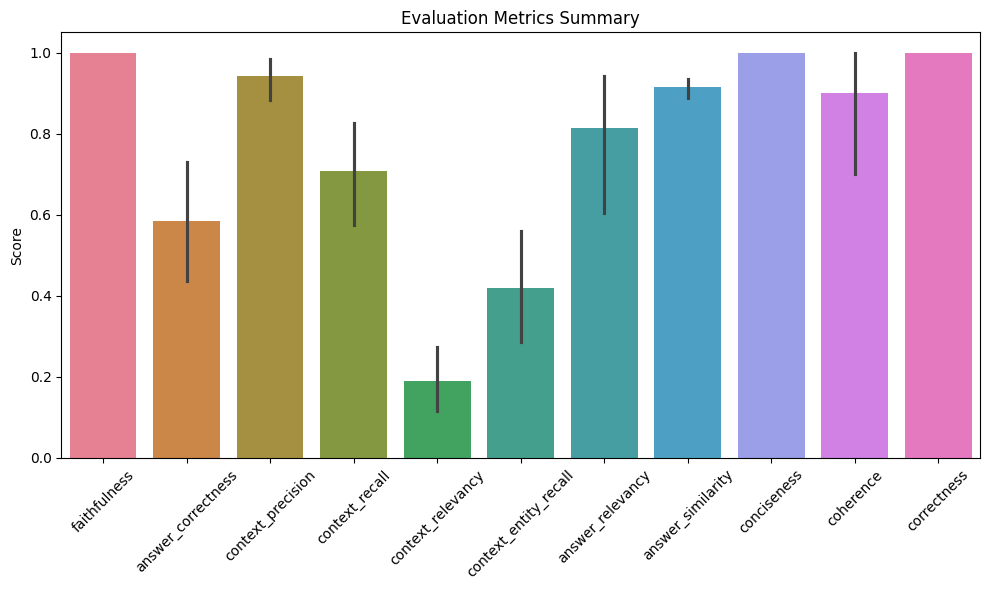

In [18]:
rag_evaluator.summarize_metrics()

# Experiment 1: Looking at the impact of context and its chunking strategy

Contrary to the apparent structure of the data, which seems to have already chunked the data according to the first proposed chunking strategy, this step will introduce the concatenation of these premade chunks into one single document. This will help us to see if it is beneficial for the LLM to have the entire document context instead of just a chunk of said document.

First, to restructure the cleantech-dataset's content structure, we can call the `preprocess()` method on the `Preprocessor` Object which was instantiated using the `concatenate_contents=True` attribute. This will turn the list of all prechunked contents into a joined string, representing the content of every document.

In [19]:
full_document_preprocessor = Preprocessor(df, explode=False, concatenate_contents=True)
df_full_content = full_document_preprocessor.preprocess()

In order to embed the processed documents we again can turn them into langchain-digestible Documents.

In [20]:
full_content_documents = create_documents(df_full_content)

assert len(full_content_documents) == len(df_full_content)

KeyboardInterrupt: 

And in order to look at this experiment in an encapsulated manner, a new `VectorStore` will be created.

In [29]:
bge_full_content_vector_store = VectorStore(embedding_function=bge_embeddings,
                                            collection="cleantech-full-content-bge-small-en")

In [30]:
%%script false --no-raise-error
bge_full_content_vector_store.add_documents(full_content_documents, verbose=True, batch_size=128)

In [31]:
bge_full_content_vector_store.similarity_search_w_scores("The company is also aiming to reduce gas flaring?")

[(Document(page_content='LNG  Mexico  Natural Gas Prices  NGI All News Access  NGI The Weekly Gas Market Report Mexico Pacific Ltd LLC  MPL continues to advance its liquefied natural gas  LNG export project for the Pacific coast of the country This week the company signed a collaboration agreement with ConocoPhillips LNG Licensing LLC and Bechtel Together the companies plan to work with construction firm Techint SA de CV to pursue  innovative lower carbon LNG design solutions  for potential future phases of the project The collaboration plans to further reduce baseline emissions by exploring  energy transition and greenhouse gas emission reduction  technologies developed by ConocoPhillips LNG and designed by Bechtel This would include  carbonadvantaged gas feedstock  and  developing a commercial strategy for supplying carbon neutral LNG in the future  said ConocoPhillips Tom Mathiasmeier president of Global Gas Power and LNG  Get in the know Access to pipelines processing plants and LN

In [32]:
rag_chain_with_full_source = RunnableParallel(
    {
        "context": bge_full_content_vector_store.get_retriever(), 
        "question": RunnablePassthrough()
    }
).assign(answer=rag_chain_from_docs)

In [33]:
rag_chain_with_full_source.invoke("Is the company aiming to reduce gas flaring?")

{'context': [Document(page_content='Global energy companies are shifting to ESG investing but what are the drivers to decarbonise and the innovative approaches being deployed In this new series Mike Scott takes the temperature of the industry s response to date as well as the challenges ahead that this shift will present The energy sector faces a turbulent transitional autumn framed by the latest report from the Intergovernmental Panel on Climate Change  IPCC and the crucial COP26 Glasgow Scotland meeting in November We re seeing a growing number of companies divesting their highcarbon assets as BHP has just done in selling its oil and gas unit to Australian compatriot Woodside However investors and campaigners are starting to point out that while this helps the seller to decarbonise it makes no difference to total carbon emissions  indeed if you sell to someone less concerned about climate change you may end up increasing carbon emissions The coal mining sector should give energy comp

In [34]:
rag_evaluator_full_content = RAGEvaluator(chain=rag_chain_with_full_source,
                                            llm_model=azure_model,
                                            embeddings=bge_embeddings)

In [35]:
rag_evaluator_full_content.create_dataset_from_df(df_eval_subset)
full_content_eval_results = rag_evaluator_full_content.evaluate(raise_exceptions=False)

Creating dataset:   0%|          | 0/10 [00:02<?, ?it/s]


KeyboardInterrupt: 

# Experiment 2: HyDE approach

In [67]:
from langchain_core.runnables import RunnablePassthrough

system = """You are an expert about the Clean Technology Sector.
            Answer the user question as best you can. Answer as though you were writing a tutorial that addressed the user question."""

hyde_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

gen_hypothetical_doc = hyde_prompt | azure_model | StrOutputParser() | RunnablePassthrough()

In [68]:
rag_chain_from_docs = (
        RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
        | ChatPromptTemplate.from_template(rag_prompt)
        | azure_model
        | StrOutputParser()
)

rag_chain_with_source = RunnableParallel(
    {
        "context": bge_vector_store.get_retriever(), 
        "question": RunnablePassthrough()
    }
).assign(answer=rag_chain_from_docs)

In [69]:
hyde_chain = ( gen_hypothetical_doc 
              | rag_chain_with_source
             )

hyde_chain.invoke(
    {
        "question": "What is the company's goal in reducing gas flaring?"
    }
)

{'context': [Document(page_content='Kahina Abdeli-Galinier, Schlumberger emissions business director, commented: “ The urgency of methane and flare challenges means emission detection, measurement, reporting and abatement approaches need to mature rapidly. To benefit the industry, SEES aspires to become the trusted partner for operators looking to reduce their emissions footprint quickly, credibly, and in the right way. To benefit the planet, our objective is to work with our customers to eliminate 1% of all anthropogenic GHG emissions by 2030. ”', metadata={'author': '', 'date': '2022-03-09', 'domain': 'azocleantech', 'title': 'Schlumberger Launches Dedicated Business to Eliminate Oil and Gas Industry’ s Methane and Routine Flare Emissions', 'url': 'https://www.azocleantech.com/news.aspx?newsID=31294'}),
  Document(page_content='Oil and gas sector emissions reductions get less press, but are also significant. In addition to an active flare-reduction program, Cairo last October signed 

# Experiment 2: Using a Multi-Query Retrieval Strategy

At the heart of the RAG is the retriever, which is responsible for finding the most relevant documents for a given question. The baseline RAG uses the vector retriever to find the most relevant document, using cosine-similarity. 

We will now experiment with a multi-query retrieval strategy. The idea is to use multiple queries to retrieve a multidude of documents and take a unique union of the results. This way we can increase the diversity of the documents and potentially improve the quality of the generated answer. 

For this we will use the MultiQueryRetriever from langchain.


In [19]:
from langchain.retrievers.multi_query import MultiQueryRetriever

In [20]:
retriever = MultiQueryRetriever.from_llm(
    retriever=bge_vector_store.get_retriever(), llm=azure_model
)

In [21]:

## using the langchain template for the prompt
template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)


generate_queries = (
        prompt_perspectives
        | azure_model
        | StrOutputParser()
        | (lambda x: x.split("\n"))
)

In [22]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
retrieval_chain = generate_queries | retriever.map() | get_unique_union

In [23]:

rag_chain_from_docs = (
        RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
        | ChatPromptTemplate.from_template(rag_prompt)
        | azure_model
        | StrOutputParser()
)

rag_chain_with_source = RunnableParallel(
    {
        "context": retrieval_chain, 
        "question": RunnablePassthrough()
    }
).assign(answer=rag_chain_from_docs)

In [24]:
rag_chain_with_full_source.invoke("Is the company aiming to reduce gas flaring?")

NameError: name 'rag_chain_with_full_source' is not defined

In [ ]:
rag_evaluator_mqt = RAGEvaluator(chain=rag_chain_with_full_source,
                                            llm_model=azure_model,
                                            embeddings=bge_embeddings)

In [ ]:
rag_evaluator_mqt.create_dataset_from_df(df_eval_subset)
mqt_eval_result = rag_evaluator_mqt.evaluate(raise_exceptions=False)

In [ ]:
rag_evaluator_mqt.summarize_metrics()

In [ ]:
rag_evaluator.summarize_metrics()

In [ ]:
rag_evaluator_full_content.summarize_metrics()